In [18]:
# -*- coding: utf-8 -*-
import pandas as pd, numpy as np
from matplotlib.axes import Axes
from matplotlib.transforms import Affine2D
from matplotlib.patches import Arc
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation
import os
import cv2

PARSER

In [3]:
class Parser():
    def __init__(self, df):
        
        #General Match Info
        self.df = df.sort_values(by='utc')
        self.pitch_length, self.pitch_width, self.match_id, self.competition_id,\
        self.stadium_id, self.first_half_start, self.first_half_end,\
        self.second_half_start, self.second_half_end = self.get_match_info()
        
        #Technical Info
        self.df_technical = self.df[["utc", "half", "isBallInPlay", "ballPossession", "type", "id", "x", "y", "z"]]
        
        self.utc, self.half, self.ball_status, self.possession, self.possession_alive,\
        self.ball_coords, self.home_coords, self.away_coords,\
        self.ball_coords_alive, self.home_coords_alive, self.away_coords_alive,\
        self.home_coords_mirr, self.home_ball_coords_mirr,\
        self.away_coords_mirr, self.away_ball_coords_mirr,\
        self.home_mirr_idx, self.away_mirr_idx, self.grouped_df = self.get_technical_info()
        
    def get_match_info(self):
        pitch_length = self.df.loc[0]["pitchLength"]
        pitch_width = self.df.loc[0]["pitchWidth"]
        match_id = self.df.loc[0]["idMatch"]
        competition_id = self.df.loc[0]["idCompetition"]
        stadium_id = self.df.loc[0]["idStadium"]
        first_half_start = self.df.loc[0]["firstHalfStart"]
        first_half_end = self.df.loc[0]["firstHalfEnd"]
        second_half_start = self.df.loc[0]["secondtHalfStart"]
        second_half_end = self.df.loc[0]["secondHalfEnd"]
        
        return pitch_length, pitch_width, match_id, competition_id, stadium_id, first_half_start,\
               first_half_end, second_half_start, second_half_end
    
    def helper_fetch(self,data_list):
        new_data_list = []
        for i in data_list:
            if isinstance(i, list):
                new_data_list.append(i[0])
            else:
                new_data_list.append(i)
        return new_data_list
    
    def helper_ball_coords(self, coords_list):
        new_coords_list = []
        for i in coords_list:
            if i is None:
                new_coords_list.append(None)
            else:
                new_coords_list.append(i[0])
        return new_coords_list
    
    def get_technical_info(self):

        #Aggregate the rows for each frame
        grouped = self.df_technical.groupby('utc')
        grouped_dic = {}
        for column in self.df_technical.columns:
            if column != 'utc':
                grouped_dic[column] = grouped[column].apply(list).reset_index()[column]

        grouped_df = pd.concat([grouped['utc'].first(), pd.DataFrame(grouped_dic)], axis=1)
        print("Grouped dataframe created")
        
        #Store relevant values
        utc = grouped_df["utc"].values
        half= self.helper_fetch(grouped_df["half"].values)
        ball_status = self.helper_fetch(grouped_df["isBallInPlay"].values)
        possession = self.helper_fetch(grouped_df["ballPossession"].values)
        print("Match Info Fetched")
        
        #Get locations
        ball_coords = []
        home_coords = []
        away_coords = []
        ball_coords_alive = []
        home_coords_alive = []
        away_coords_alive = []
        possession_alive = []
        xs = grouped_df["x"].values
        ys = grouped_df["y"].values
        types = grouped_df["type"].values
        for i in range(len(xs)):
            if np.isnan(ball_status[i])== False: # Check presence of ball status
                frame_ball_coords = []
                frame_home_coords = []
                frame_away_coords = []
                for j,t in enumerate(types[i]):
                    x = xs[i][j] // 100 # convert the coordinates to have the pitch in vertical alignment
                    y = ys[i][j] // 100 # divide by 100 to have measurements in terms of meters
                    x_new = y 
                    y_new = -x 

                    if t == 0: # home coords
                        frame_home_coords.append([x_new, y_new])
                    elif t == 1: # away coords
                        frame_away_coords.append([x_new, y_new])
                    elif t == 7: # ball coords
                        frame_ball_coords.append([x_new, y_new])

                ball_coords.append(frame_ball_coords)
                home_coords.append(frame_home_coords)
                away_coords.append(frame_away_coords)

                if ball_status[i] == 1: # store ball alive frames
                    ball_coords_alive.append(frame_ball_coords)
                    home_coords_alive.append(frame_home_coords)
                    away_coords_alive.append(frame_away_coords)
                    possession_alive.append(possession[i])

            else: # Ball status not present
                ball_coords.append(None)
                home_coords.append(None)
                away_coords.append(None)
        
        ball_coords_adjusted = self.helper_ball_coords(ball_coords)
        ball_coords_alive_adjusted = self.helper_ball_coords(ball_coords_alive)

        print("Technical Info Fetched")
        #Include mirrored locations
        home_coords_mirr = []
        away_coords_mirr = []
        home_ball_coords_mirr = []
        away_ball_coords_mirr = []
        home_mirr_idx = []
        away_mirr_idx = []
        for i in range(len(ball_coords_alive_adjusted)):
            temp_home_avg_y = np.average(np.array(home_coords_alive[i])[:,1])
            temp_away_avg_y = np.average(np.array(away_coords_alive[i])[:,1])

            if temp_home_avg_y <= temp_away_avg_y: # mirror away
                home_mirr_idx.append(i)
                new_temp_home_coords = list(np.array(home_coords_alive[i]))
                new_temp_away_coords = list(-np.array(away_coords_alive[i]))
                new_temp_home_ball_coords = list(np.array(ball_coords_alive_adjusted[i]))
                new_temp_away_ball_coords = list(-np.array(ball_coords_alive_adjusted[i]))

                home_coords_mirr.append(new_temp_home_coords)
                away_coords_mirr.append(new_temp_away_coords)
                home_ball_coords_mirr.append(new_temp_home_ball_coords)
                away_ball_coords_mirr.append(new_temp_away_ball_coords)

            else:                                  # mirror home
                away_mirr_idx.append(i)
                new_temp_home_coords = list(-np.array(home_coords_alive[i]))
                new_temp_away_coords = list(np.array(away_coords_alive[i]))
                new_temp_home_ball_coords = list(-np.array(ball_coords_alive_adjusted[i]))
                new_temp_away_ball_coords = list(np.array(ball_coords_alive_adjusted[i]))

                home_coords_mirr.append(new_temp_home_coords)
                away_coords_mirr.append(new_temp_away_coords)
                home_ball_coords_mirr.append(new_temp_home_ball_coords)
                away_ball_coords_mirr.append(new_temp_away_ball_coords)

        print("Mirrored Coordinates Computed")

        return utc, half, ball_status, possession, possession_alive,\
               ball_coords_adjusted, home_coords, away_coords,\
               ball_coords_alive_adjusted, home_coords_alive, away_coords_alive,\
               home_coords_mirr, home_ball_coords_mirr,\
               away_coords_mirr, away_ball_coords_mirr,\
               home_mirr_idx, away_mirr_idx, grouped_df
               


ANALYSIS

In [4]:
df = pd.read_csv("data/playerTracking_A03.csv")
match = Parser(df)

Grouped dataframe created
Match Info Fetched
Technical Info Fetched
Mirrored Coordinates Computed


1 - Ball Location

In [531]:
def get_ball_location(match):
   y_mid_up = 17.5
   y_mid_down = -17.5
   y_boundry = 53
   x_boundry = 34
   penalty_area_x = 20.16
   penalty_area_y = 36
   ball_location = []
   for idx,i in enumerate(match.home_ball_coords_mirr):
      if i[0] > -penalty_area_x and i[0] < penalty_area_x and\
         i[1] > penalty_area_y and i[1] <= y_boundry: # Penalty Area Away
         
         ball_location.append("Penalty area of away team")

      elif i[0] > -penalty_area_x and i[0] < penalty_area_x and\
         i[1] < -penalty_area_y and i[1] >= -y_boundry: # Penalty Area Home

         ball_location.append("Penalty area of home team")

      elif i[0]>= -x_boundry and i[0] <= x_boundry and\
           i[1] > y_mid_up and i[1] <= y_boundry : # Final Third Home - First Third Away
         
         ball_location.append("Final third area of home team - First third area of away team ")
         
      elif i[0]>= -x_boundry and i[0] <= x_boundry and\
           i[1] >= y_mid_down and i[1] <= y_mid_up: # Middle Third
         
         ball_location.append("Middle third area")
      
      elif i[0]>= -x_boundry and i[0] <= x_boundry and\
           i[1] >= -y_boundry and i[1] < y_mid_down: # First Third Home - Final Third Away
         
         ball_location.append("Final third area of away team - First third area of home team ")
      
      else:
         ball_location.append("Out of the pitch")
    
   return ball_location

In [532]:
ball_location = get_ball_location(match)

2- Running Total of Effective Time (possession %) 

In [810]:
def get_running_total_possession(match):
    possession = np.array(match.possession)
    
    # Filter for "Home" and "Away" possessions
    filtered_possession = possession[(possession == "Home") | (possession == "Away")]
    
    # Calculate the running total of possession percentages
    home_possession = (filtered_possession == "Home").astype(int)
    away_possession = (filtered_possession == "Away").astype(int)
    
    cumulative_home = np.cumsum(home_possession)
    cumulative_away = np.cumsum(away_possession)

    total_possession = cumulative_home + cumulative_away
    home_pct = np.round(cumulative_home / total_possession * 100,2)
    away_pct = np.round(cumulative_away / total_possession * 100,2)
    
    running_total_poss = np.column_stack((home_pct, away_pct)).tolist()
    
    return running_total_poss


In [811]:
running_total_poss = get_running_total_possession(match)

3- Running Total of Ball Out of Play

In [803]:
def get_running_total_ball_out_of_play(match):
    possession = np.array(match.possession)
    halves = np.array(match.half)

    match_start_frame = min(np.where(possession == "Home")[0][0], np.where(possession == "Away")[0][0])
    match_end_frame = max(np.where(possession == "Home")[0][-1], np.where(possession == "Away")[0][-1])

    half_time_start = np.where(halves == "First Half")[0][-1]
    half_time_end = np.where(halves == "Second Half")[0][0]

    ball_status = np.array(match.ball_status)  # Convert to NumPy array here

    # Combine the ball_status frames before and after half-time
    ball_status = np.concatenate((ball_status[match_start_frame: half_time_start], ball_status[half_time_end: match_end_frame]))

    # Filter for available ball status frames (0 for dead, 1 for alive)
    filtered_ball_status = ball_status[(ball_status == 1) | (ball_status == 0)]

    # Calculate the running total of "ball out of play"
    ball_alive = (filtered_ball_status == 1).astype(int)
    ball_dead = (filtered_ball_status == 0).astype(int)

    cumulative_ball_alive = np.cumsum(ball_alive)
    cumulative_ball_dead = np.cumsum(ball_dead)

    total_status = cumulative_ball_alive + cumulative_ball_dead
    ball_dead_pct = np.round(cumulative_ball_dead / total_status * 100)

    return list(ball_dead_pct)


In [804]:
running_total_ball_out_of_play = get_running_total_ball_out_of_play(match)

4- Pressure Classification

In [770]:
def adjust_edges(edges):
    e_xs = edges.get_xdata()
    e_ys = edges.get_ydata()
    edges2 = []
    tmp = []
    for i in range(len(e_xs)):
        if i%3 == 2:
            edges2.append(list(tmp))
            tmp = []
        else:
            tmp.append([e_xs[i], e_ys[i]])
    return np.array(edges2)

def get_neighbour_edges(attacker, edges):
    # Convert the list of edges into a NumPy array for efficient indexing
    edges_array = np.array(edges)

    # Create a mask for matching conditions
    condition_1 = (attacker[0] == edges_array[:, 0, 0]) & (attacker[1] == edges_array[:, 0, 1])
    condition_2 = (attacker[0] == edges_array[:, 1, 0]) & (attacker[1] == edges_array[:, 1, 1])

    # Use logical OR to combine the conditions
    mask = condition_1 | condition_2

    # Apply the mask to filter relevant edges
    relevant_edges = edges_array[mask]

    return relevant_edges

def is_indirect(defender, relevant_edges, d_indirect = 2):
    for e in relevant_edges:
        n1 = e[0]
        n2 = e[1]
        if max(n1[0], n2[0]) >= defender[0] and min(n1[0], n2[0]) <= defender[0] and\
           max(n1[1], n2[1]) >= defender[1] and min(n1[1], n2[1]) <= defender[1]:
            dist = np.linalg.norm(np.cross(np.array(n2) - np.array(n1), np.array(n1) - np.array(defender))) / np.linalg.norm(np.array(n2) - np.array(n1))
            if dist <= d_indirect:
                return True
    return False


In [771]:
def classify_pressure(match,
                      d_control = 3,
                      d_indirect = 2,
                      pressure_r0 = 3,
                      pressure_r1 = 2.5,
                      pressure_r2 = 2,
                      pressure_r3 = 1,
                      angle_h0 = 30,
                      angle_h1 = 60,
                      angle_h2 = 90):    
    ax = plt.gca()
    pressure_types = []
    for i,p in enumerate(match.possession_alive):
        if i % 10000 == 0:
            print(i)
        temp_home_coords = np.array(match.home_coords_alive[i])
        temp_away_coords = np.array(match.away_coords_alive[i])
        temp_ball_coords = np.array(match.ball_coords_alive[i])

        home_players_dists_to_ball = np.sqrt(np.sum((temp_home_coords - temp_ball_coords) ** 2, axis = 1))
        away_players_dists_to_ball = np.sqrt(np.sum((temp_away_coords - temp_ball_coords) ** 2, axis = 1))
        home_players_in_control = home_players_dists_to_ball[home_players_dists_to_ball <= d_control]
        away_players_in_control = away_players_dists_to_ball[away_players_dists_to_ball <= d_control]
        closest_home_player_index = np.argmin(home_players_dists_to_ball)
        closest_away_player_index = np.argmin(away_players_dists_to_ball)
        closest_home_player = temp_home_coords[closest_home_player_index]
        closest_away_player = temp_away_coords[closest_away_player_index]

        flag = False

        if p == "Home":
            if len(home_players_in_control) == 0:    # None of the home team players are in control of the ball 
                if len(away_players_in_control) > 0: # Away team is in control - direct Pressure
                    pressure_types.append("Direct Pressure")
                    flag = True
                else:                                # No one is in control of the ball - No Pressure
                    pressure_types.append("No Pressure")
                    flag = True
            else:
                # --- DIRECT PRESSURE Home ---
                #Defeding teams' distances to the ball
                away_in_r0 = away_players_dists_to_ball[away_players_dists_to_ball <= pressure_r0] 
                away_in_r1 = away_players_dists_to_ball[away_players_dists_to_ball <= pressure_r1]  
                away_in_r2 = away_players_dists_to_ball[away_players_dists_to_ball <= pressure_r2]  
                away_in_r3 = away_players_dists_to_ball[away_players_dists_to_ball <= pressure_r3]

                #Proximity and Angle
                ball_attacker_vec = closest_home_player - temp_ball_coords #vector between ball and attacker
                attacker_defender_vec = closest_home_player - closest_away_player #vector between attacker and defender

                if (np.linalg.norm(ball_attacker_vec) * np.linalg.norm(attacker_defender_vec)) == 0: #avoid division by 0
                    if len(away_in_r3) > 0:
                        pressure_types.append("Direct Pressure")
                        flag = True
                else:
                    cosine_angle = np.dot(ball_attacker_vec, attacker_defender_vec) / (np.linalg.norm(ball_attacker_vec) * np.linalg.norm(attacker_defender_vec))
                    if cosine_angle <=1 and cosine_angle >= -1:
                        angle = np.arccos(cosine_angle)
                        angle_degrees = np.degrees(angle)
                        if len(away_in_r0) > 0 and  angle_degrees <= angle_h0: #section 0 
                            pressure_types.append("Direct Pressure")
                            flag = True
                        elif len(away_in_r1) > 0 and  angle_degrees > angle_h0 and angle_degrees <= angle_h1: #section 1
                            pressure_types.append("Direct Pressure")
                            flag = True
                        elif len(away_in_r2) > 0 and  angle_degrees > angle_h1 and angle_degrees < angle_h2: #section 2
                            pressure_types.append("Direct Pressure")
                            flag = True
                        elif len(away_in_r3) > 0 and  angle_degrees >= angle_h2: #section 3
                            pressure_types.append("Direct Pressure")
                            flag = True

                # --- INDIRECT PRESSURE Home ---
                if flag == False:
                    edges,_ = ax.triplot(temp_home_coords[:,0], temp_home_coords[:,1])
                    edges = adjust_edges(edges)
                    relevant_edges = get_neighbour_edges(closest_home_player, edges)                
                    for ap in temp_away_coords:
                        indirect_pressure_flag = is_indirect(ap, relevant_edges, d_indirect)
                        if indirect_pressure_flag == True:
                            pressure_types.append("Indirect Pressure")
                            flag = True
                            break

                    if flag == False:
                        pressure_types.append("No Pressure")
                        flag = True
                    plt.close()

        elif p == "Away":
            if len(away_players_in_control) == 0:    # None of the away team players are in control of the ball 
                if len(home_players_in_control) > 0: # Home team is in control - direct Pressure
                    pressure_types.append("Direct Pressure")
                    flag = True
                else:                                # No one is in control of the ball - No Pressure
                    pressure_types.append("No Pressure")
                    flag = True
            else:
                # --- DIRECT PRESSURE Away ---
                #Defeding teams' distances to the ball
                home_in_r0 = home_players_dists_to_ball[home_players_dists_to_ball <= pressure_r0] 
                home_in_r1 = home_players_dists_to_ball[home_players_dists_to_ball <= pressure_r1]  
                home_in_r2 = home_players_dists_to_ball[home_players_dists_to_ball <= pressure_r2]  
                home_in_r3 = home_players_dists_to_ball[home_players_dists_to_ball <= pressure_r3]
                
                #Proximity and Angle
                ball_attacker_vec = closest_away_player - temp_ball_coords #vector between ball and attacker
                attacker_defender_vec = closest_away_player - closest_home_player #vector between attacker and defender

                if (np.linalg.norm(ball_attacker_vec) * np.linalg.norm(attacker_defender_vec)) == 0: #avoid division by 0
                    if len(home_in_r3) > 0:
                        pressure_types.append("Direct Pressure")
                        flag = True
                else:
                    cosine_angle = np.dot(ball_attacker_vec, attacker_defender_vec) / (np.linalg.norm(ball_attacker_vec) * np.linalg.norm(attacker_defender_vec))
                    if cosine_angle <=1 and cosine_angle >= -1:
                        angle = np.arccos(cosine_angle)
                        angle_degrees = np.degrees(angle)
                        if len(home_in_r0) > 0 and  angle_degrees <= angle_h0: #section 0 
                            pressure_types.append("Direct Pressure")
                            flag = True
                        elif len(home_in_r1) > 0 and  angle_degrees > angle_h0 and angle_degrees <= angle_h1: #section 1
                            pressure_types.append("Direct Pressure")
                            flag = True
                        elif len(home_in_r2) > 0 and  angle_degrees > angle_h1 and angle_degrees < angle_h2: #section 2
                            pressure_types.append("Direct Pressure")
                            flag = True
                        elif len(home_in_r3) > 0 and  angle_degrees >= angle_h2: #section 3
                            pressure_types.append("Direct Pressure")
                            flag = True

                # --- INDIRECT PRESSURE Home ---
                if flag == False:
                    edges,_ = ax.triplot(temp_away_coords[:,0], temp_away_coords[:,1])
                    edges = adjust_edges(edges)
                    relevant_edges = get_neighbour_edges(closest_away_player, edges)
                    for hp in temp_home_coords:
                        indirect_pressure_flag = is_indirect(hp, relevant_edges, d_indirect)
                        if indirect_pressure_flag == True:
                            pressure_types.append("Indirect Pressure")
                            flag = True
                            break
                    if flag == False:
                        pressure_types.append("No Pressure")
                        flag = True

                    plt.close()

    return np.array(pressure_types)
        

In [ ]:
pressure_types = classify_pressure(match)

5- Progression Between Zones

In [68]:
def classify_progression(match, poss_threshold = 60, pass_gap = 10, y_dm = -17.5, y_mf = 17.5, d_control = 3):
    home_dm = []
    away_dm = []
    home_mf = []
    away_mf = []
    home_dm_failed = []
    away_dm_failed= []
    home_mf_failed = []
    away_mf_failed = []
    ball_coords_home = np.array(match.home_ball_coords_mirr)
    ball_coords_away = np.array(match.away_ball_coords_mirr)
    possessions = np.array(match.possession_alive)
    for i,p in enumerate(possessions):
        if i + poss_threshold > len(possessions) - 1:
            break
        if p == "Home":
            if ball_coords_home[i][1] < y_dm and ball_coords_home[i+1][1] >= y_dm: # Home Progression - Defensive Third to Midfield Third
                if np.all(possessions[i + 1: i + 1 + poss_threshold] == "Home") and np.all(ball_coords_home[i + 1: i + 1 + poss_threshold,1] >= y_dm): # ensure possession and ball location
                    home_ball_dist = []
                    for hi, h in enumerate(match.home_coords_alive[i + pass_gap :i + 1 + poss_threshold]):
                        home_ball_dist.append(np.min(np.linalg.norm(np.array(h) - np.array(match.ball_coords_alive[hi + i + pass_gap]), axis= -1)))

                    home_ball_dist = np.array(home_ball_dist)
                    if np.any(home_ball_dist <= d_control): # ensure a home team player controls the ball
                        home_dm.append(i) # success 
                    else:
                        home_dm_failed.append(i) # fail
                else:
                    home_dm_failed.append(i) # fail
            elif ball_coords_home[i][1] < y_mf and ball_coords_home[i+1][1] >= y_mf: # Home Progression - Midfield Third to Attacking Third
                if np.all(possessions[i + 1: i + 1 + poss_threshold] == "Home") and np.all(ball_coords_home[i + 1: i + 1 + poss_threshold,1] >= y_mf): # ensure possession and ball location
                    home_ball_dist = []
                    for hi, h in enumerate(match.home_coords_alive[i + pass_gap :i + 1 + poss_threshold]):
                        home_ball_dist.append(np.min(np.linalg.norm(np.array(h) - np.array(match.ball_coords_alive[hi + i + pass_gap]), axis= -1)))

                    home_ball_dist = np.array(home_ball_dist)
                    if np.any(home_ball_dist <= d_control): # ensure a home team player controls the ball
                        home_mf.append(i) # success 
                    else:
                        home_mf_failed.append(i) # fail
                else:
                    home_mf_failed.append(i) # fail
        elif p == "Away":
            if ball_coords_away[i][1] < y_dm and ball_coords_away[i+1][1] >= y_dm: # Away Progression - Defensive Third to Midfield Third
                if np.all(possessions[i + 1: i + 1 + poss_threshold] == "Away") and np.all(ball_coords_away[i + 1: i + 1 + poss_threshold,1] >= y_dm): # ensure possession and ball location
                    away_ball_dist = []
                    for ai, a in enumerate(match.away_coords_alive[i + pass_gap :i + 1 + poss_threshold]):
                        away_ball_dist.append(np.min(np.linalg.norm(np.array(a) - np.array(match.ball_coords_alive[ai + i + pass_gap]), axis= -1)))

                    away_ball_dist = np.array(away_ball_dist)
                    if np.any(away_ball_dist <= d_control): # ensure a away team player controls the ball
                        away_dm.append(i) # success 
                    else:
                        away_dm_failed.append(i) # fail
                else:
                    away_dm_failed.append(i) # fail
            elif ball_coords_away[i][1] < y_mf and ball_coords_away[i+1][1] >= y_mf: # Away Progression - Midfield Third to Attacking Third
                if np.all(possessions[i + 1: i + 1 + poss_threshold] == "Away") and np.all(ball_coords_away[i + 1: i + 1 + poss_threshold,1] >= y_mf): # ensure possession and ball location
                    away_ball_dist = []
                    for ai, a in enumerate(match.away_coords_alive[i + pass_gap :i + 1 + poss_threshold]):
                        away_ball_dist.append(np.min(np.linalg.norm(np.array(a) - np.array(match.ball_coords_alive[ai + i + pass_gap]), axis= -1)))

                    away_ball_dist = np.array(away_ball_dist)
                    if np.any(away_ball_dist <= d_control): # ensure a away team player controls the ball
                        away_mf.append(i) # success 
                    else:
                        away_mf_failed.append(i) # fail
                else:
                    away_mf_failed.append(i) # fail
                    
    print(away_mf)
    home_dms = [len(home_dm), len(home_dm_failed), round(len(home_dm) / (len(home_dm) + len(home_dm_failed)),2), round(len(home_dm_failed) / (len(home_dm) + len(home_dm_failed)),2)]
    away_dms = [len(away_dm), len(away_dm_failed), round(len(away_dm) / (len(away_dm) + len(away_dm_failed)),2), round(len(away_dm_failed) / (len(away_dm) + len(away_dm_failed)),2)]
    home_mfs = [len(home_mf), len(home_mf_failed), round(len(home_mf) / (len(home_mf) + len(home_mf_failed)),2), round(len(home_mf_failed) / (len(home_mf) + len(home_mf_failed)),2)]
    away_mfs = [len(away_mf), len(away_mf_failed), round(len(away_mf) / (len(away_mf) + len(away_mf_failed)),2), round(len(away_mf_failed) / (len(away_mf) + len(away_mf_failed)),2)]

    return home_dms, away_dms, home_mfs, away_mfs


In [69]:
home_dms, away_dms, home_mfs, away_mfs = classify_progression(match)
print(home_dms)
print(away_dms)
print(home_mfs)
print(away_mfs)

[1512, 6677, 7067, 7540, 11856, 14917, 15785, 24213, 24515, 25142, 26235, 27157, 28832, 29478, 34425, 35775, 36150, 40017, 42799, 45028, 46999, 47403, 48207, 49903, 51045, 52362, 53719, 55674, 56546, 58152, 60364, 62452, 62969, 65554, 72181, 72491, 75676, 77283, 78667, 79308, 79600, 82389, 84496, 86579]
[45, 37, 0.55, 0.45]
[62, 40, 0.61, 0.39]
[35, 44, 0.44, 0.56]
[44, 40, 0.52, 0.48]


Visualization

In [40]:
def draw_pitch(
    ax: Axes,
    pitch_center: tuple = (0, 0),
    pitch_length: float = 105,
    pitch_width: float = 68,
    linewidth: float = 1.2,
    linecolor="black",
    background_color=None,
    zorder: int = -10,
    orient_vertical: bool = False,
):
    """Draw a football pitch on a given axes.
    The pitch is fitted according to the provided center and width/length arguments.
    Scale is not guaranteed.
    Parameters
    ----------
    ax : matplotlib.axes.Axes
        Axes to draw the pitch on
    pitch_center : tuple
        Center of the pitch, by default (0, 34). The center is the point in the
        middle of the pitch, lengthwise and widthwise respectively. If orient_vertical
        is False (default), this translates to x and y axes.
    pitch_length : float
        Length of the pitch, by default 105
    pitch_width : float
        Width of the pitch, by default 68
    linewidth : float
        Width of the lines, passed to plot calls and patch initializations, by default 1.2
    linecolor : color
        Color of the lines, passed to plot calls and patch initializations, by default "black"
    background_color : color
        Color of the plot background as a matplotlib color, by default None
    zorder : int, optional
        Plotting order of the pitch on the axes, by default -10
    orient_vertical : bool, optional
        Change the pitch orientation to vertical, by default False
    """
    if orient_vertical:
        transform = Affine2D().rotate_deg(90).scale(-1, 1) + ax.transData
    else:
        transform = ax.transData
    x = lambda x: (x / 130) * pitch_length + pitch_center[0] - pitch_length / 2
    y = lambda y: (y / 90) * pitch_width + pitch_center[1] - pitch_width / 2
    rat_x = pitch_length / 130
    rat_y = pitch_width / 90
    plot_arguments = dict(
        color=linecolor, zorder=zorder, transform=transform, linewidth=linewidth
    )
    # Pitch Outline & Centre Line
    ax.plot([x(0), x(0)], [y(0), y(90)], **plot_arguments)
    ax.plot([x(0), x(130)], [y(90), y(90)], **plot_arguments)
    ax.plot([x(130), x(130)], [y(90), y(0)], **plot_arguments)
    ax.plot([x(130), x(0)], [y(0), y(0)], **plot_arguments)
    ax.plot([x(65), x(65)], [y(0), y(90)], **plot_arguments)
    # Left Penalty Area
    ax.plot([x(20), x(20)], [y(70.5), y(19.5)], **plot_arguments)
    ax.plot([x(0), x(20)], [y(70.5), y(70.5)], **plot_arguments)
    ax.plot([x(20), x(0)], [y(19.5), y(19.5)], **plot_arguments)
    # Right Penalty Area
    ax.plot([x(130), x(110)], [y(70.5), y(70.5)], **plot_arguments)
    ax.plot([x(110), x(110)], [y(70.5), y(19.5)], **plot_arguments)
    ax.plot([x(110), x(130)], [y(19.5), y(19.5)], **plot_arguments)
    # Left 6-yard Box
    ax.plot([x(0), x(6)], [y(56.16), y(56.16)], **plot_arguments)
    ax.plot([x(6), x(6)], [y(56.16), y(33.84)], **plot_arguments)
    ax.plot([x(6), x(0)], [y(33.84), y(33.84)], **plot_arguments)
    # Right 6-yard Box
    ax.plot([x(130), x(124)], [y(56.16), y(56.16)], **plot_arguments)
    ax.plot([x(124), x(124)], [y(56.16), y(33.84)], **plot_arguments)
    ax.plot([x(124), x(130)], [y(33.84), y(33.84)], **plot_arguments)

    # Prepare circles
    centre_circle = plt.Circle((x(65), y(45)), 9.15, fill=False, **plot_arguments)
    centre_spot = plt.Circle((x(65), y(45)), linewidth / 2, **plot_arguments)
    left_pen_spot = plt.Circle((x(13), y(45)), linewidth / 4, **plot_arguments)
    right_pen_spot = plt.Circle((x(117), y(45)), linewidth / 4, **plot_arguments)
    # Draw Circles
    ax.add_patch(centre_circle)
    ax.add_patch(centre_spot)
    ax.add_patch(left_pen_spot)
    ax.add_patch(right_pen_spot)
    # Prepare Arcs
    left_arc = Arc(
        (x(13.5), y(45)),
        height=20.75 * rat_y,
        width=20.75 * rat_x,
        angle=0,
        theta1=312,
        theta2=48,
        **plot_arguments,
    )
    right_arc = Arc(
        (x(115.5), y(45)),
        height=20 * rat_y,
        width=20 * rat_x,
        angle=0,
        theta1=128,
        theta2=232,
        **plot_arguments,
    )
    # Draw Arcs
    ax.add_patch(left_arc)
    ax.add_patch(right_arc)
    if background_color is not None:
        ax.set_facecolor(background_color)

        

In [14]:
def basic_plotter(match, frame, team = "Home", is_modified = True):
    player_color = ""
    coords = []
    ball_coords = []
    if team == "Home":
        player_color = "r"
        if is_modified:
            coords = match.home_coords_mirr[frame]
            ball_coords = match.home_ball_coords_mirr[frame]
        else:
            coords = match.home_coords_alive[frame]
            ball_coords = match.ball_coords_alive[frame]
    elif team == "Away":
        player_color = "b"
        if is_modified:
            coords = match.away_coords_mirr[frame]
            ball_coords = match.away_ball_coords_mirr[frame]
        else:
            coords = match.away_coords_alive[frame]
            ball_coords = match.ball_coords_alive[frame]
    else:
        print("Invalid Input")
    
    mus  = coords 
    x = [i[0] for i in mus]
    y = [i[1] for i in mus]
    fig = plt.figure(figsize=(6.8, 10.5))
    ax = plt.gca()
    ax.set_facecolor('white')
    ax.set_xticks([])
    ax.set_yticks([])
    draw_pitch(ax, orient_vertical=True, pitch_center=(0, 0))   
    mus = np.asarray([[pair[0], pair[1]] for pair in mus])
    for p in range(len(coords)):
        ax.scatter([mus[p][0]], [mus[p][1]], s=100, color = player_color, edgecolors='k')

    ax.scatter([ball_coords[0]], [ball_coords[1]], s=50, color = 'green', edgecolors='k')
    #ax.scatter([20.16], [-36], s=50, color = 'gray', edgecolors='k')
    ax.text(-30, 54, s = team, color='red')

In [145]:
def basic_plotter_together(match, frame, i):
       
    coords_home = match.home_coords_alive[frame]
    coords_away = match.away_coords_alive[frame]
    
    mus_home  = coords_home 
    mus_away  = coords_away
    fig = plt.figure(figsize=(6.8, 10.5))
    ax = plt.gca()
    ax.set_facecolor('white')
    ax.set_xticks([])
    ax.set_yticks([])
    draw_pitch(ax, orient_vertical=True, pitch_center=(0, 0))  
    mus_home = np.asarray([[pair[0], pair[1]] for pair in mus_home])
    mus_away = np.asarray([[pair[0], pair[1]] for pair in mus_away])
    for p in range(len(coords_home)):
        ax.scatter([mus_home[p][0]], [mus_home[p][1]], s=100, color = 'red', edgecolors='k')
    
    for p in range(len(coords_away)):
        ax.scatter([mus_away[p][0]], [mus_away[p][1]], s=100, color = 'blue', edgecolors='k')

    ax.scatter([match.ball_coords_alive[frame][0]], [match.ball_coords_alive[frame][1]], s=50, color = 'green', edgecolors='k')
    
    
    if i >= 0 and i <10:
        plt.savefig(f"first_goal_frames/match0{i}.png")
    else:
        plt.savefig(f"first_goal_frames/match{i}.png")
    plt.close()
    
    

In [593]:
def delaunay_plotter(match, frame, pressure = ""):
    pos = match.possession_alive[frame]
    home_coords = np.array(match.home_coords_alive[frame])
    away_coords = np.array(match.away_coords_alive[frame])
    ball_coords = np.array(match.ball_coords_alive[frame])
    edges = []
    fig, ax = plt.subplots(figsize=(6.8, 10.5))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_facecolor('white')
    draw_pitch(ax, orient_vertical=True, pitch_center=(0, 0))

    if pos == "Home":
        edges,_ = ax.triplot(home_coords[:,0], home_coords[:,1])
        edges = adjust_edges(edges)
    elif pos == "Away":
        edges,_ = ax.triplot(away_coords[:,0], away_coords[:,1])
        edges = adjust_edges(edges)

    for h in home_coords:
        ax.scatter([h[0]], [h[1]], s=100, color = "red", edgecolors='k')

    for h in away_coords:
        ax.scatter([h[0]], [h[1]], s=100, color = "blue", edgecolors='k')

    ax.scatter([ball_coords[0]], [ball_coords[1]], s=50, color = 'green', edgecolors='k')
    
    if pressure != "":
        ax.text(10, 54, pressure,  fontsize = 15, color = 'black')
        
    if pos == "Home":
        ax.text(-34, 54, "Possession: " + pos,  fontsize = 15, color = 'red')
        for e in edges:
            ax.plot((e[0][0], e[1][0]), (e[0][1], e[1][1]), alpha = 1, linewidth = 1, color = "red")

    elif pos == "Away":
        ax.text(-34, 54, "Possession: " + pos,  fontsize = 15, color = 'blue')
        for e in edges:
            ax.plot((e[0][0], e[1][0]), (e[0][1], e[1][1]), alpha = 1, linewidth = 1, color = "blue")

In [642]:
def ball_location_plotter(match, frame, ball_location):
       
    coords_home = match.home_coords_alive[frame]
    coords_away = match.away_coords_alive[frame]
    poss = match.possession_alive[frame]
    ball_loc = ball_location[frame]

    mus_home  = coords_home 
    mus_away  = coords_away
    fig = plt.figure(figsize=(6.8, 10.5))
    ax = plt.gca()
    ax.set_facecolor('white')
    ax.set_xticks([])
    ax.set_yticks([])
    draw_pitch(ax, orient_vertical=True, pitch_center=(0, 0))  
    mus_home = np.asarray([[pair[0], pair[1]] for pair in mus_home])
    mus_away = np.asarray([[pair[0], pair[1]] for pair in mus_away])
    for p in range(len(coords_home)):
        ax.scatter([mus_home[p][0]], [mus_home[p][1]], s=100, color = 'red', edgecolors='k')
    
    for p in range(len(coords_away)):
        ax.scatter([mus_away[p][0]], [mus_away[p][1]], s=100, color = 'blue', edgecolors='k')

    ax.scatter([match.ball_coords_alive[frame][0]], [match.ball_coords_alive[frame][1]], s=50, color = 'green', edgecolors='k')

    if ball_loc == "Final third area of home team - First third area of away team " or ball_loc == "Final third area of away team - First third area of home team ":
        ax.text(-37, 54, ball_loc,  fontsize = 11, color = 'black', weight = "bold")
    elif ball_loc == "Penalty area of home team" or  ball_loc == "Penalty area of away team":
        ax.text(-16, 54, ball_loc,  fontsize = 11, color = 'black', weight = "bold")
    else:
        ax.text(-11, 54, ball_loc,  fontsize = 11, color = 'black', weight = "bold")
    """"
    if poss == "Home":
        ax.text(-34, 54, "Possession: " + poss,  fontsize = 15, color = 'red')
    elif poss == "Away":
        ax.text(-34, 54, "Possession: " + poss,  fontsize = 15, color = 'blue')
    """

In [146]:
i = 1
for f in range(1650, 1755):
    basic_plotter_together(match, f, i)
    i += 1

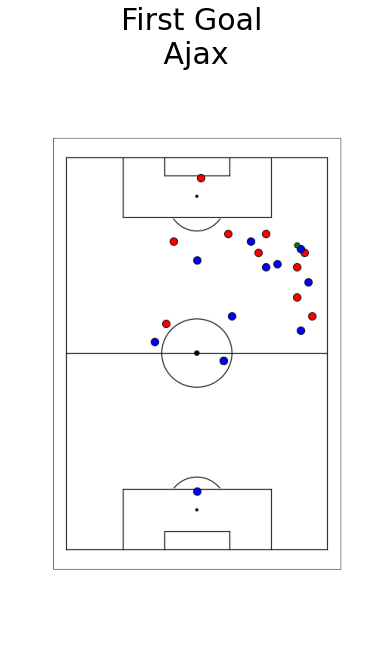

In [150]:
# Specify the directory path you want to list files from
directory_path = "first_goal_frames"

# Use the os.listdir() function to get a list of filenames in the directory
file_names = os.listdir(directory_path)

# Create a list of full file paths by joining the directory path with the file names
image_files = sorted([os.path.join(directory_path, file) for file in file_names])

# Create a function to update the animation frames
def update(frame):
    plt.clf()  # Clear the previous frame
    image = plt.imread(image_files[frame])    
    # Clear the axis for each frame
    plt.imshow(image)
    plt.axis('off')
    plt.title("First Goal\n Ajax", fontsize = 30)
     
# Create the animation
width = 6.8
height = 10.5
mult = 1
ani = FuncAnimation(plt.figure(figsize=(width * mult, height * mult)), update, frames=len(image_files), blit=False)

writergif = animation.PillowWriter(fps=25)
ani.save('first_goal.gif', writer=writergif)
